## Importing all of the necessary libraries

In [1]:
import pandas as pd 
import string
import nltk
import re
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import FreqDist
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn import metrics
import pickle
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

### Loading data files for NLTK

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
stop_words = stopwords.words('english')
stop_words += list(string.punctuation)
stop_words += list(['br', '...'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
print(stop_words[0:20])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']


### Loading in the prepared data set

In [4]:
df = pd.read_csv('cleaned_data.csv.zip')

### Looking at the loaded data to ensure it was loaded properly

In [5]:
df.head()

customer_id  product_id  product_parent product_category  helpful_votes  \
0     25416447  B00P170G5Q       201428350         Wireless            2.0   
1     24545878  B007PRVA96       437290944         Wireless            0.0   
2     12801326  B000UU7ZPS       134650851         Wireless            1.0   
3     51044660  B00SHZDSRW       249550984         Wireless            0.0   
4     45144433  B0098FKHBU       411042352         Wireless            0.0   

   total_votes vine verified_purchase  \
0          2.0    N                 Y   
1          0.0    N                 Y   
2          1.0    N                 Y   
3          0.0    N                 Y   
4          0.0    N                 Y   

                                     review_headline  \
0  I cannot close one side of the case completely...   
1                                        Great case!   
2                                      Excellent GPS   
3                                Great Buy and Value   
4                                        pretty case   

                                         review_body  sentiment  
0  I cannot close one side of the case completely...          0  
1  This case is so pretty and sparkly and I get c...          1  
2  I previously owned the Garmin C330. This was a...          1  
3  Bought this for my granddaughter and she absol...          1  
4  This is a pretty case and seems to be a good p...          1

##### Normalize and clean the data

In [5]:
cols = ['review_headline', 'review_body']
def lowercase(cols_to_change=None, df=df):
    for col in cols_to_change:
        df[col] = df[col].apply(lambda x: x.lower())

In [6]:
# Change al of the text to lower case for easier processing
lowercase(cols)
df.head()

customer_id  product_id  product_parent product_category  helpful_votes  \
0     25416447  B00P170G5Q       201428350         Wireless            2.0   
1     24545878  B007PRVA96       437290944         Wireless            0.0   
2     12801326  B000UU7ZPS       134650851         Wireless            1.0   
3     51044660  B00SHZDSRW       249550984         Wireless            0.0   
4     45144433  B0098FKHBU       411042352         Wireless            0.0   

   total_votes vine verified_purchase  \
0          2.0    N                 Y   
1          0.0    N                 Y   
2          1.0    N                 Y   
3          0.0    N                 Y   
4          0.0    N                 Y   

                                     review_headline  \
0  i cannot close one side of the case completely...   
1                                        great case!   
2                                      excellent gps   
3                                great buy and value   
4                                        pretty case   

                                         review_body  sentiment  
0  i cannot close one side of the case completely...          0  
1  this case is so pretty and sparkly and i get c...          1  
2  i previously owned the garmin c330. this was a...          1  
3  bought this for my granddaughter and she absol...          1  
4  this is a pretty case and seems to be a good p...          1

In [7]:
def clean_text(text):
    """
    input: text
    
    output: text with symbols removed
    """
    symbols = ['(', ')', '/', ':', '*', '#', '$', '@', '+', '=', '>', '<', "\\", "'", '`', "\'", '\"']
    for symbol in symbols:
        text = text.replace(symbol, "")
        
    text = re.sub("'ve", " have", text)
    text = re.sub("'n't", " not", text)
    text = re.sub("'ll", " will", text)
    text = re.sub('\d','', text)
    text = re.sub("--", " ", text)
    return text

In [8]:
df['review_headline'] = df['review_headline'].apply(clean_text)
df['review_body'] = df['review_body'].apply(clean_text)
df.head()

customer_id  product_id  product_parent product_category  helpful_votes  \
0     25416447  B00P170G5Q       201428350         Wireless            2.0   
1     24545878  B007PRVA96       437290944         Wireless            0.0   
2     12801326  B000UU7ZPS       134650851         Wireless            1.0   
3     51044660  B00SHZDSRW       249550984         Wireless            0.0   
4     45144433  B0098FKHBU       411042352         Wireless            0.0   

   total_votes vine verified_purchase  \
0          2.0    N                 Y   
1          0.0    N                 Y   
2          1.0    N                 Y   
3          0.0    N                 Y   
4          0.0    N                 Y   

                                     review_headline  \
0  i cannot close one side of the case completely...   
1                                        great case!   
2                                      excellent gps   
3                                great buy and value   
4                                        pretty case   

                                         review_body  sentiment  
0  i cannot close one side of the case completely...          0  
1  this case is so pretty and sparkly and i get c...          1  
2  i previously owned the garmin c. this was a go...          1  
3  bought this for my granddaughter and she absol...          1  
4  this is a pretty case and seems to be a good p...          1

In [9]:
  
def sent_tokenizer(text):
    """
    input: block of text
    
    return: tokenized block of text (list of words)
    """
    tokens = nltk.sent_tokenize(text)
    return tokens

In [10]:
  
def word_tokenizer(text):
    """
    input: block of text
    
    return: tokenized block of text (list of words)
    """
    tokens = nltk.word_tokenize(text)
    return tokens

#### Tokenizing each review by sentence
<a id='tokenizing'></a>

In [11]:
df['tokenized_review_headline'] = df['review_headline'].apply(sent_tokenizer)
df['tokenized_review_body'] = df['review_body'].apply(sent_tokenizer)
df.head()

customer_id  product_id  product_parent product_category  helpful_votes  \
0     25416447  B00P170G5Q       201428350         Wireless            2.0   
1     24545878  B007PRVA96       437290944         Wireless            0.0   
2     12801326  B000UU7ZPS       134650851         Wireless            1.0   
3     51044660  B00SHZDSRW       249550984         Wireless            0.0   
4     45144433  B0098FKHBU       411042352         Wireless            0.0   

   total_votes vine verified_purchase  \
0          2.0    N                 Y   
1          0.0    N                 Y   
2          1.0    N                 Y   
3          0.0    N                 Y   
4          0.0    N                 Y   

                                     review_headline  \
0  i cannot close one side of the case completely...   
1                                        great case!   
2                                      excellent gps   
3                                great buy and value   
4                                        pretty case   

                                         review_body  sentiment  \
0  i cannot close one side of the case completely...          0   
1  this case is so pretty and sparkly and i get c...          1   
2  i previously owned the garmin c. this was a go...          1   
3  bought this for my granddaughter and she absol...          1   
4  this is a pretty case and seems to be a good p...          1   

                           tokenized_review_headline  \
0  [i cannot close one side of the case completel...   
1                                      [great case!]   
2                                    [excellent gps]   
3                              [great buy and value]   
4                                      [pretty case]   

                               tokenized_review_body  
0  [i cannot close one side of the case completel...  
1  [this case is so pretty and sparkly and i get ...  
2  [i previously owned the garmin c. this was a g...  
3  [bought this for my granddaughter and she abso...  
4  [this is a pretty case and seems to be a good ...

In [12]:
df.tokenized_review_body[20]

['had the gamin  gps first for a week.',
 'used it on a trip to pigeon forge tn and did fine getting me there.',
 'i just couldnt find my house.',
 'i live in a  year old subdivsion so ther shouldnt be any reason for it not too.',
 'took it back and got the garmin wt and it can find my house with no problem.',
 'the spoken street names and the traffic features are nice also.',
 'the bluetooth workes great but is a little agravating to disconnect from it if you dont want everyone in the car to hear your conversation.',
 'all in all i like it and plan on giving one for a christmas present.']

#### Tokenizing each review by word

In [13]:
df['tokenized_review_headline'] = df['review_headline'].apply(word_tokenizer)
df['tokenized_review_body'] = df['review_body'].apply(word_tokenizer)
df.head()

customer_id  product_id  product_parent product_category  helpful_votes  \
0     25416447  B00P170G5Q       201428350         Wireless            2.0   
1     24545878  B007PRVA96       437290944         Wireless            0.0   
2     12801326  B000UU7ZPS       134650851         Wireless            1.0   
3     51044660  B00SHZDSRW       249550984         Wireless            0.0   
4     45144433  B0098FKHBU       411042352         Wireless            0.0   

   total_votes vine verified_purchase  \
0          2.0    N                 Y   
1          0.0    N                 Y   
2          1.0    N                 Y   
3          0.0    N                 Y   
4          0.0    N                 Y   

                                     review_headline  \
0  i cannot close one side of the case completely...   
1                                        great case!   
2                                      excellent gps   
3                                great buy and value   
4                                        pretty case   

                                         review_body  sentiment  \
0  i cannot close one side of the case completely...          0   
1  this case is so pretty and sparkly and i get c...          1   
2  i previously owned the garmin c. this was a go...          1   
3  bought this for my granddaughter and she absol...          1   
4  this is a pretty case and seems to be a good p...          1   

                           tokenized_review_headline  \
0  [i, can, not, close, one, side, of, the, case,...   
1                                   [great, case, !]   
2                                   [excellent, gps]   
3                           [great, buy, and, value]   
4                                     [pretty, case]   

                               tokenized_review_body  
0  [i, can, not, close, one, side, of, the, case,...  
1  [this, case, is, so, pretty, and, sparkly, and...  
2  [i, previously, owned, the, garmin, c., this, ...  
3  [bought, this, for, my, granddaughter, and, sh...  
4  [this, is, a, pretty, case, and, seems, to, be...

In [14]:
df.tokenized_review_body[20]

['had',
 'the',
 'gamin',
 'gps',
 'first',
 'for',
 'a',
 'week',
 '.',
 'used',
 'it',
 'on',
 'a',
 'trip',
 'to',
 'pigeon',
 'forge',
 'tn',
 'and',
 'did',
 'fine',
 'getting',
 'me',
 'there',
 '.',
 'i',
 'just',
 'couldnt',
 'find',
 'my',
 'house',
 '.',
 'i',
 'live',
 'in',
 'a',
 'year',
 'old',
 'subdivsion',
 'so',
 'ther',
 'shouldnt',
 'be',
 'any',
 'reason',
 'for',
 'it',
 'not',
 'too',
 '.',
 'took',
 'it',
 'back',
 'and',
 'got',
 'the',
 'garmin',
 'wt',
 'and',
 'it',
 'can',
 'find',
 'my',
 'house',
 'with',
 'no',
 'problem',
 '.',
 'the',
 'spoken',
 'street',
 'names',
 'and',
 'the',
 'traffic',
 'features',
 'are',
 'nice',
 'also',
 '.',
 'the',
 'bluetooth',
 'workes',
 'great',
 'but',
 'is',
 'a',
 'little',
 'agravating',
 'to',
 'disconnect',
 'from',
 'it',
 'if',
 'you',
 'dont',
 'want',
 'everyone',
 'in',
 'the',
 'car',
 'to',
 'hear',
 'your',
 'conversation',
 '.',
 'all',
 'in',
 'all',
 'i',
 'like',
 'it',
 'and',
 'plan',
 'on',
 'givi

#### Removing stop words from each review and headline
<a id='stopwords'></a>

In [15]:
df['stopped_review_headline'] = df['tokenized_review_headline'].apply(lambda x: [w for w in x if w not in stop_words])
df['stopped_review_body'] = df['tokenized_review_body'].apply(lambda x: [w for w in x if w not in stop_words])
df.head()

customer_id  product_id  product_parent product_category  helpful_votes  \
0     25416447  B00P170G5Q       201428350         Wireless            2.0   
1     24545878  B007PRVA96       437290944         Wireless            0.0   
2     12801326  B000UU7ZPS       134650851         Wireless            1.0   
3     51044660  B00SHZDSRW       249550984         Wireless            0.0   
4     45144433  B0098FKHBU       411042352         Wireless            0.0   

   total_votes vine verified_purchase  \
0          2.0    N                 Y   
1          0.0    N                 Y   
2          1.0    N                 Y   
3          0.0    N                 Y   
4          0.0    N                 Y   

                                     review_headline  \
0  i cannot close one side of the case completely...   
1                                        great case!   
2                                      excellent gps   
3                                great buy and value   
4                                        pretty case   

                                         review_body  sentiment  \
0  i cannot close one side of the case completely...          0   
1  this case is so pretty and sparkly and i get c...          1   
2  i previously owned the garmin c. this was a go...          1   
3  bought this for my granddaughter and she absol...          1   
4  this is a pretty case and seems to be a good p...          1   

                           tokenized_review_headline  \
0  [i, can, not, close, one, side, of, the, case,...   
1                                   [great, case, !]   
2                                   [excellent, gps]   
3                           [great, buy, and, value]   
4                                     [pretty, case]   

                               tokenized_review_body  \
0  [i, can, not, close, one, side, of, the, case,...   
1  [this, case, is, so, pretty, and, sparkly, and...   
2  [i, previously, owned, the, garmin, c., this, ...   
3  [bought, this, for, my, granddaughter, and, sh...   
4  [this, is, a, pretty, case, and, seems, to, be...   

                stopped_review_headline  \
0  [close, one, side, case, completely]   
1                         [great, case]   
2                      [excellent, gps]   
3                   [great, buy, value]   
4                        [pretty, case]   

                                 stopped_review_body  
0  [close, one, side, case, completely, keeps, pu...  
1  [case, pretty, sparkly, get, compliments, time...  
2  [previously, owned, garmin, c., good, gps, uni...  
3  [bought, granddaughter, absolutely, loves, lik...  
4  [pretty, case, seems, good, protector, althoug...

In [16]:
print(df.stopped_review_body[1340])

['ordered', 'battery', 'replacement', 'samsung', 'galaxy', 'desperate', 'need', 'replacing', 'received', 'battery', 'fairly', 'good', 'amount', 'time', 'immediately', 'plugged', 'charged', 'completely', 'using', 'first', 'use', 'managed', 'keep', 'charge', 'minutes', 'sucked', 'suddenly', 'phone', 'turned', 'turned', 'phone', 'back', 'minutes', 'later', 'find', 'battery', 'obviously', 'defective', 'worth', 'purchase', 'needless', 'say', 'seeing', 'find', 'replacement']


#### Creating a new feature of reviews with POS tagging
<a id='pos_tags'></a>

In [17]:
def pos_tagger(text):
    """
    input: block of text
    
    return: tokenized block of text (list of words)
    """
    tags = nltk.pos_tag(text)
    return tags

In [18]:
df['body_pos_tagged'] = df['stopped_review_body'].apply(pos_tagger)
df['headline_pos_tagged'] = df['stopped_review_headline'].apply(pos_tagger)
df.head()

customer_id  product_id  product_parent product_category  helpful_votes  \
0     25416447  B00P170G5Q       201428350         Wireless            2.0   
1     24545878  B007PRVA96       437290944         Wireless            0.0   
2     12801326  B000UU7ZPS       134650851         Wireless            1.0   
3     51044660  B00SHZDSRW       249550984         Wireless            0.0   
4     45144433  B0098FKHBU       411042352         Wireless            0.0   

   total_votes vine verified_purchase  \
0          2.0    N                 Y   
1          0.0    N                 Y   
2          1.0    N                 Y   
3          0.0    N                 Y   
4          0.0    N                 Y   

                                     review_headline  \
0  i cannot close one side of the case completely...   
1                                        great case!   
2                                      excellent gps   
3                                great buy and value   
4                                        pretty case   

                                         review_body  sentiment  \
0  i cannot close one side of the case completely...          0   
1  this case is so pretty and sparkly and i get c...          1   
2  i previously owned the garmin c. this was a go...          1   
3  bought this for my granddaughter and she absol...          1   
4  this is a pretty case and seems to be a good p...          1   

                           tokenized_review_headline  \
0  [i, can, not, close, one, side, of, the, case,...   
1                                   [great, case, !]   
2                                   [excellent, gps]   
3                           [great, buy, and, value]   
4                                     [pretty, case]   

                               tokenized_review_body  \
0  [i, can, not, close, one, side, of, the, case,...   
1  [this, case, is, so, pretty, and, sparkly, and...   
2  [i, previously, owned, the, garmin, c., this, ...   
3  [bought, this, for, my, granddaughter, and, sh...   
4  [this, is, a, pretty, case, and, seems, to, be...   

                stopped_review_headline  \
0  [close, one, side, case, completely]   
1                         [great, case]   
2                      [excellent, gps]   
3                   [great, buy, value]   
4                        [pretty, case]   

                                 stopped_review_body  \
0  [close, one, side, case, completely, keeps, pu...   
1  [case, pretty, sparkly, get, compliments, time...   
2  [previously, owned, garmin, c., good, gps, uni...   
3  [bought, granddaughter, absolutely, loves, lik...   
4  [pretty, case, seems, good, protector, althoug...   

                                     body_pos_tagged  \
0  [(close, RB), (one, CD), (side, NN), (case, NN...   
1  [(case, NN), (pretty, RB), (sparkly, JJ), (get...   
2  [(previously, RB), (owned, VBN), (garmin, JJ),...   
3  [(bought, VBN), (granddaughter, NN), (absolute...   
4  [(pretty, RB), (case, NN), (seems, VBZ), (good...   

                                 headline_pos_tagged  
0  [(close, RB), (one, CD), (side, NN), (case, NN...  
1                          [(great, JJ), (case, NN)]  
2                       [(excellent, JJ), (gps, NN)]  
3              [(great, JJ), (buy, NN), (value, NN)]  
4                         [(pretty, RB), (case, NN)]

In [19]:
#def bi_grams(text):
#    """
#    input: block of text
#    
#    return: bi-grams (list of words)
#    """
#    bigrms = nltk.bigrams(text)
#    yield bigrms

In [20]:
#df['bi_grams_body'] = df['stopped_review_body'].apply(bi_grams)
#df['bi_grams_headlline'] = df['stopped_review_headline'].apply(bi_grams)
#df.head()

<a id='all_words'></a>
#### Making a set of all words from all reviews and a list of all reviews for frequency distribution

In [21]:
all_words = set()
for review in df['stopped_review_body']:
    all_words.update(review)
for review in df['stopped_review_headline']:
    all_words.update(review)
len(all_words)

309918

In [22]:
df_pos = df.loc[df['sentiment'] == 1]
df_neg = df.loc[df['sentiment'] == 0]

In [23]:
df_neg.head()

customer_id  product_id  product_parent product_category  helpful_votes  \
0      25416447  B00P170G5Q       201428350         Wireless            2.0   
7      16991454  B001DAT0XE       483794136         Wireless            1.0   
12     43316877  B001H9NR2Q       905467579         Wireless            0.0   
16     36703090  B004AGJRY0       645400177         Wireless            1.0   
17     18893047  B005VO5G68       158170317         Wireless            0.0   

    total_votes vine verified_purchase  \
0           2.0    N                 Y   
7           2.0    N                 Y   
12          0.0    N                 N   
16          2.0    N                 Y   
17          1.0    N                 Y   

                                      review_headline  \
0   i cannot close one side of the case completely...   
7                  very weak adhesive , will not stay   
12                       great if you dont update it!   
16                                 cant use with skin   
17                                                 no   

                                          review_body  sentiment  \
0   i cannot close one side of the case completely...          0   
7   i got this to mount an ipad to my car but the ...          0   
12  bought unit  a brick and mortar and plugged it...          0   
16  i, like most folks, have their cell phones wra...          0   
17  it didnt do the job that it was made for.. it ...          0   

                            tokenized_review_headline  \
0   [i, can, not, close, one, side, of, the, case,...   
7          [very, weak, adhesive, ,, will, not, stay]   
12              [great, if, you, dont, update, it, !]   
16                            [cant, use, with, skin]   
17                                               [no]   

                                tokenized_review_body  \
0   [i, can, not, close, one, side, of, the, case,...   
7   [i, got, this, to, mount, an, ipad, to, my, ca...   
12  [bought, unit, a, brick, and, mortar, and, plu...   
16  [i, ,, like, most, folks, ,, have, their, cell...   
17  [it, didnt, do, the, job, that, it, was, made,...   

                 stopped_review_headline  \
0   [close, one, side, case, completely]   
7                 [weak, adhesive, stay]   
12                 [great, dont, update]   
16                     [cant, use, skin]   
17                                    []   

                                  stopped_review_body  \
0   [close, one, side, case, completely, keeps, pu...   
7   [got, mount, ipad, car, adhesive, weak, came, ...   
12  [bought, unit, brick, mortar, plugged, immedia...   
16  [like, folks, cell, phones, wrapped, skins, pr...   
17  [didnt, job, made, for.., regular, screen, pro...   

                                      body_pos_tagged  \
0   [(close, RB), (one, CD), (side, NN), (case, NN...   
7   [(got, VBD), (mount, NN), (ipad, NN), (car, NN...   
12  [(bought, VBN), (unit, NN), (brick, NN), (mort...   
16  [(like, IN), (folks, NNS), (cell, VBP), (phone...   
17  [(didnt, NN), (job, NN), (made, VBD), (for.., ...   

                                  headline_pos_tagged  
0   [(close, RB), (one, CD), (side, NN), (case, NN...  
7            [(weak, JJ), (adhesive, JJ), (stay, NN)]  
12            [(great, JJ), (dont, NN), (update, NN)]  
16                [(cant, NN), (use, NN), (skin, NN)]  
17                                                 []

<a id='cancatenation'></a>
#### Creating a cancatenation of all reviews for TF-IDF processing

In [24]:
reviews_concat = []
for review in df['stopped_review_body']:
    reviews_concat += review
for review in df['stopped_review_headline']:
    reviews_concat += review

In [25]:
print(len(reviews_concat)), reviews_concat[0:100]

14941773


(None,
 ['close',
  'one',
  'side',
  'case',
  'completely',
  'keeps',
  'putting',
  'phone',
  'silentvibrate',
  'otherwise',
  'would',
  'similar',
  'lifeproof',
  'case',
  'pretty',
  'sparkly',
  'get',
  'compliments',
  'time',
  'plan',
  'getting',
  'future',
  'previously',
  'owned',
  'garmin',
  'c.',
  'good',
  'gps',
  'unit',
  'sort',
  'large',
  'didnt',
  'mind',
  'lack',
  'voice',
  'announcements',
  'street',
  'names',
  'got',
  'city',
  'streets',
  'may',
  'feet',
  'apart',
  'often',
  'took',
  'wrong',
  'turn',
  'situations',
  'garmin',
  'reasonably',
  'good',
  'job',
  'recalculating',
  'new',
  'route',
  'destination',
  'owned',
  'c',
  'year',
  'got',
  'stolen',
  'airport',
  'took',
  'eyes',
  'minute',
  'opportunity',
  'get',
  'nuvi',
  'researched',
  'various',
  'models',
  'believe',
  'garmin',
  'nuvi',
  'offered',
  'best',
  'price',
  'features',
  'desired',
  'didnt',
  'need',
  'bluetooth',
  'device',
  'm

<a id='freq_dist'></a>
#### Creating a Frequency Distribution

In [26]:
reviews_freqdist = FreqDist(reviews_concat)
reviews_freqdist.most_common(50)

[('great', 173159),
 ('one', 125183),
 ('good', 113721),
 ('like', 99621),
 ('love', 84166),
 ('would', 80540),
 ('stars', 76482),
 ('book', 75766),
 ('well', 70815),
 ('get', 68286),
 ('product', 65826),
 ('use', 65443),
 ('time', 64424),
 ('really', 58815),
 ('five', 58123),
 ('dont', 48858),
 ('much', 48736),
 ('easy', 46379),
 ('also', 46159),
 ('even', 44408),
 ('little', 43455),
 ('works', 42772),
 ('price', 42532),
 ('first', 41328),
 ('nice', 41153),
 ('work', 41051),
 ('best', 40736),
 ('game', 40103),
 ('buy', 39829),
 ('quality', 39189),
 ('read', 38469),
 ('im', 37707),
 ('bought', 37092),
 ('new', 35205),
 ('better', 34763),
 ('way', 34310),
 ('back', 33715),
 ('used', 33462),
 ('two', 33029),
 ('perfect', 32843),
 ('could', 32655),
 ('still', 32516),
 ('recommend', 32509),
 ('got', 31888),
 ('made', 31068),
 ('ive', 29872),
 ('make', 29634),
 ('many', 29111),
 ('years', 27734),
 ('see', 26954)]

In [27]:
pos_reviews_concat = []
for review in df_pos['stopped_review_body']:
    pos_reviews_concat += review
for review in df_pos['stopped_review_headline']:
    pos_reviews_concat += review

In [28]:
pos_reviews_freqdist = FreqDist(pos_reviews_concat)
pos_reviews_freqdist.most_common(50)

[('great', 165680),
 ('good', 100762),
 ('one', 97195),
 ('like', 81610),
 ('love', 81261),
 ('stars', 72043),
 ('book', 65784),
 ('well', 63156),
 ('would', 59916),
 ('five', 57419),
 ('use', 53959),
 ('get', 51627),
 ('time', 50721),
 ('product', 50303),
 ('really', 49704),
 ('easy', 44181),
 ('much', 39954),
 ('works', 39445),
 ('also', 39162),
 ('little', 38700),
 ('price', 38604),
 ('best', 38243),
 ('nice', 37827),
 ('dont', 33798),
 ('read', 33482),
 ('first', 32215),
 ('quality', 32163),
 ('even', 32081),
 ('perfect', 31995),
 ('game', 31704),
 ('im', 30131),
 ('bought', 28713),
 ('recommend', 28583),
 ('buy', 28265),
 ('new', 28142),
 ('better', 27956),
 ('work', 27791),
 ('used', 27308),
 ('way', 27118),
 ('still', 26502),
 ('ive', 25191),
 ('got', 24510),
 ('made', 24508),
 ('excellent', 24358),
 ('many', 24278),
 ('could', 24064),
 ('back', 23907),
 ('two', 23870),
 ('make', 23733),
 ('story', 23149)]

In [29]:
neg_reviews_concat = []
for review in df_neg['stopped_review_body']:
    neg_reviews_concat += review
for review in df_neg['stopped_review_headline']:
    neg_reviews_concat += review

In [30]:
neg_reviews_freqdist = FreqDist(neg_reviews_concat)
neg_reviews_freqdist.most_common(50)

[('one', 27988),
 ('would', 20624),
 ('like', 18011),
 ('get', 16659),
 ('product', 15523),
 ('dont', 15060),
 ('time', 13703),
 ('work', 13260),
 ('good', 12959),
 ('even', 12327),
 ('buy', 11564),
 ('use', 11484),
 ('money', 10014),
 ('book', 9982),
 ('back', 9808),
 ('two', 9159),
 ('first', 9113),
 ('really', 9111),
 ('much', 8782),
 ('could', 8591),
 ('game', 8399),
 ('bought', 8379),
 ('didnt', 8177),
 ('well', 7659),
 ('im', 7576),
 ('great', 7479),
 ('got', 7378),
 ('way', 7192),
 ('new', 7063),
 ('never', 7056),
 ('quality', 7026),
 ('doesnt', 7023),
 ('also', 6997),
 ('bad', 6836),
 ('better', 6807),
 ('made', 6560),
 ('star', 6510),
 ('used', 6154),
 ('still', 6014),
 ('amazon', 5909),
 ('make', 5901),
 ('another', 5733),
 ('waste', 5622),
 ('cant', 5572),
 ('disappointed', 5447),
 ('know', 5235),
 ('see', 5102),
 ('want', 5085),
 ('go', 5067),
 ('problem', 5023)]

In [31]:
freq_dist_df = pd.DataFrame(reviews_freqdist.most_common(50))
freq_dist_df.head()

0       1
0  great  173159
1    one  125183
2   good  113721
3   like   99621
4   love   84166

In [32]:
pos_freq_dist_df = pd.DataFrame(pos_reviews_freqdist.most_common(50))
pos_freq_dist_df.head()

0       1
0  great  165680
1   good  100762
2    one   97195
3   like   81610
4   love   81261

In [33]:
neg_freq_dist_df = pd.DataFrame(neg_reviews_freqdist.most_common(50))

neg_freq_dist_df.head()

0      1
0      one  27988
1    would  20624
2     like  18011
3      get  16659
4  product  15523

<a id='freq_dist_graph'></a>
# Visualizations

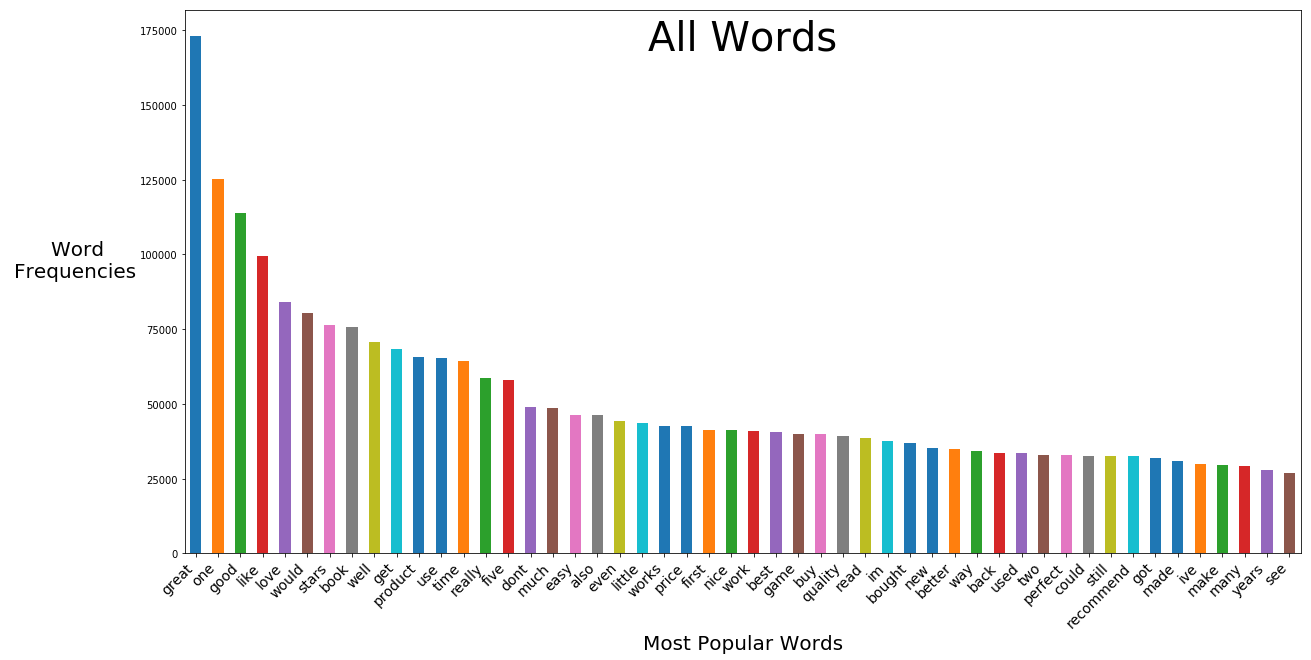

In [34]:
plt.figure(figsize=(20,10))
freq_dist_df.groupby(0).sum()[1].sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=45, fontsize=14, ha='right')
plt.title('All Words', fontsize=40, pad=-40)
plt.ylabel('Word     \n Frequencies', rotation='horizontal', fontsize=20, wrap='True', ha='right')
plt.xlabel('Most Popular Words', fontsize=20, ha='center')
plt.savefig('all_words_bar.png')
plt.show()

<a id='neg_freq_dist'></a>
#### Graphing the frequency distribution of the words in negative reviews

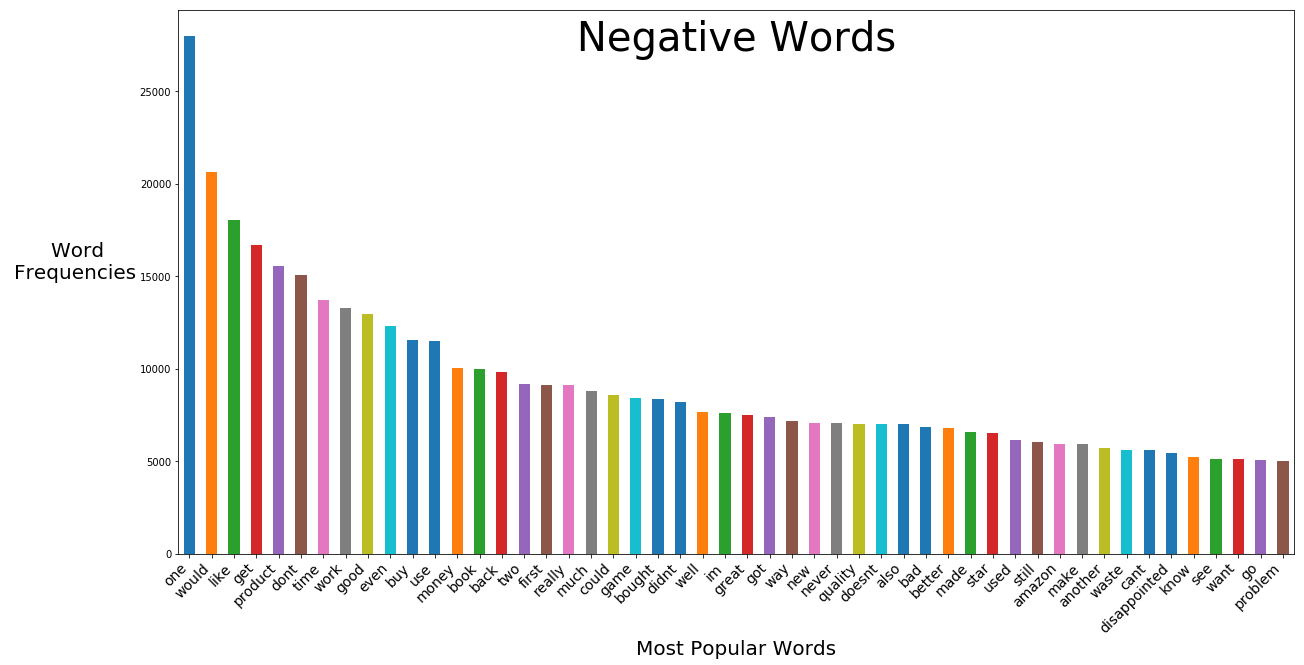

In [35]:
plt.figure(figsize=(20,10))
neg_freq_dist_df.groupby(0).sum()[1].sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=45, fontsize=14, ha='right')
plt.title('Negative Words', fontsize=40, pad=-40)
plt.ylabel('Word     \n Frequencies', rotation='horizontal', fontsize=20, wrap='True', ha='right')
plt.xlabel('Most Popular Words', fontsize=20, ha='center')
plt.savefig('neg_words_bar.png')
plt.show()

<a id='pos_freq_dist'></a>
#### Graphing the frequency distribution of the words in positive reviews

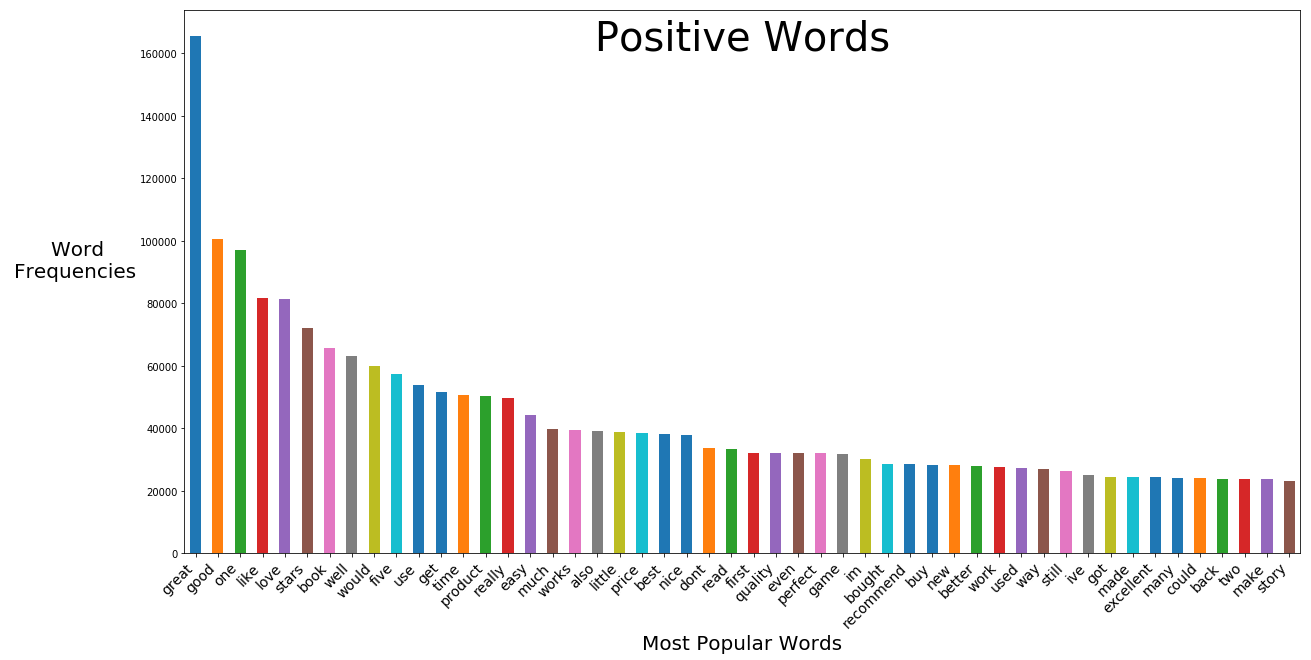

In [36]:
plt.figure(figsize=(20,10))
pos_freq_dist_df.groupby(0).sum()[1].sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=45, fontsize=14, ha='right')
plt.title('Positive Words', fontsize=40, pad=-40)
plt.ylabel('Word     \n Frequencies', rotation='horizontal', fontsize=20, wrap='True', ha='right')
plt.xlabel('Most Popular Words', fontsize=20, ha='center')
plt.savefig('pos_words_bar.png')
plt.show()

In [37]:
all_words_str = []
for review in df['stopped_review_body']:
    for word in review:
        all_words_str.append(word)
for review in df['stopped_review_headline']:
    for word in review:
        all_words_str.append(word)
len(all_words_str)

14941773

In [38]:
print(all_words_str[0:40])

['close', 'one', 'side', 'case', 'completely', 'keeps', 'putting', 'phone', 'silentvibrate', 'otherwise', 'would', 'similar', 'lifeproof', 'case', 'pretty', 'sparkly', 'get', 'compliments', 'time', 'plan', 'getting', 'future', 'previously', 'owned', 'garmin', 'c.', 'good', 'gps', 'unit', 'sort', 'large', 'didnt', 'mind', 'lack', 'voice', 'announcements', 'street', 'names', 'got', 'city']


In [39]:
all_neg_words = []
for review in df_neg['stopped_review_body']:
    for word in review:
        all_neg_words.append(word)
for review in df_neg['stopped_review_headline']:
    for word in review:
        all_neg_words.append(word)
len(all_neg_words)

2789978

In [40]:
all_pos_words = []
for review in df_pos['stopped_review_body']:
    for word in review:
        all_pos_words.append(word)
for review in df_pos['stopped_review_headline']:
    for word in review:
        all_pos_words.append(word)
len(all_pos_words)

12151795

#### Generate a WordCloud of all words
<a id='all_words_cloud'></a>

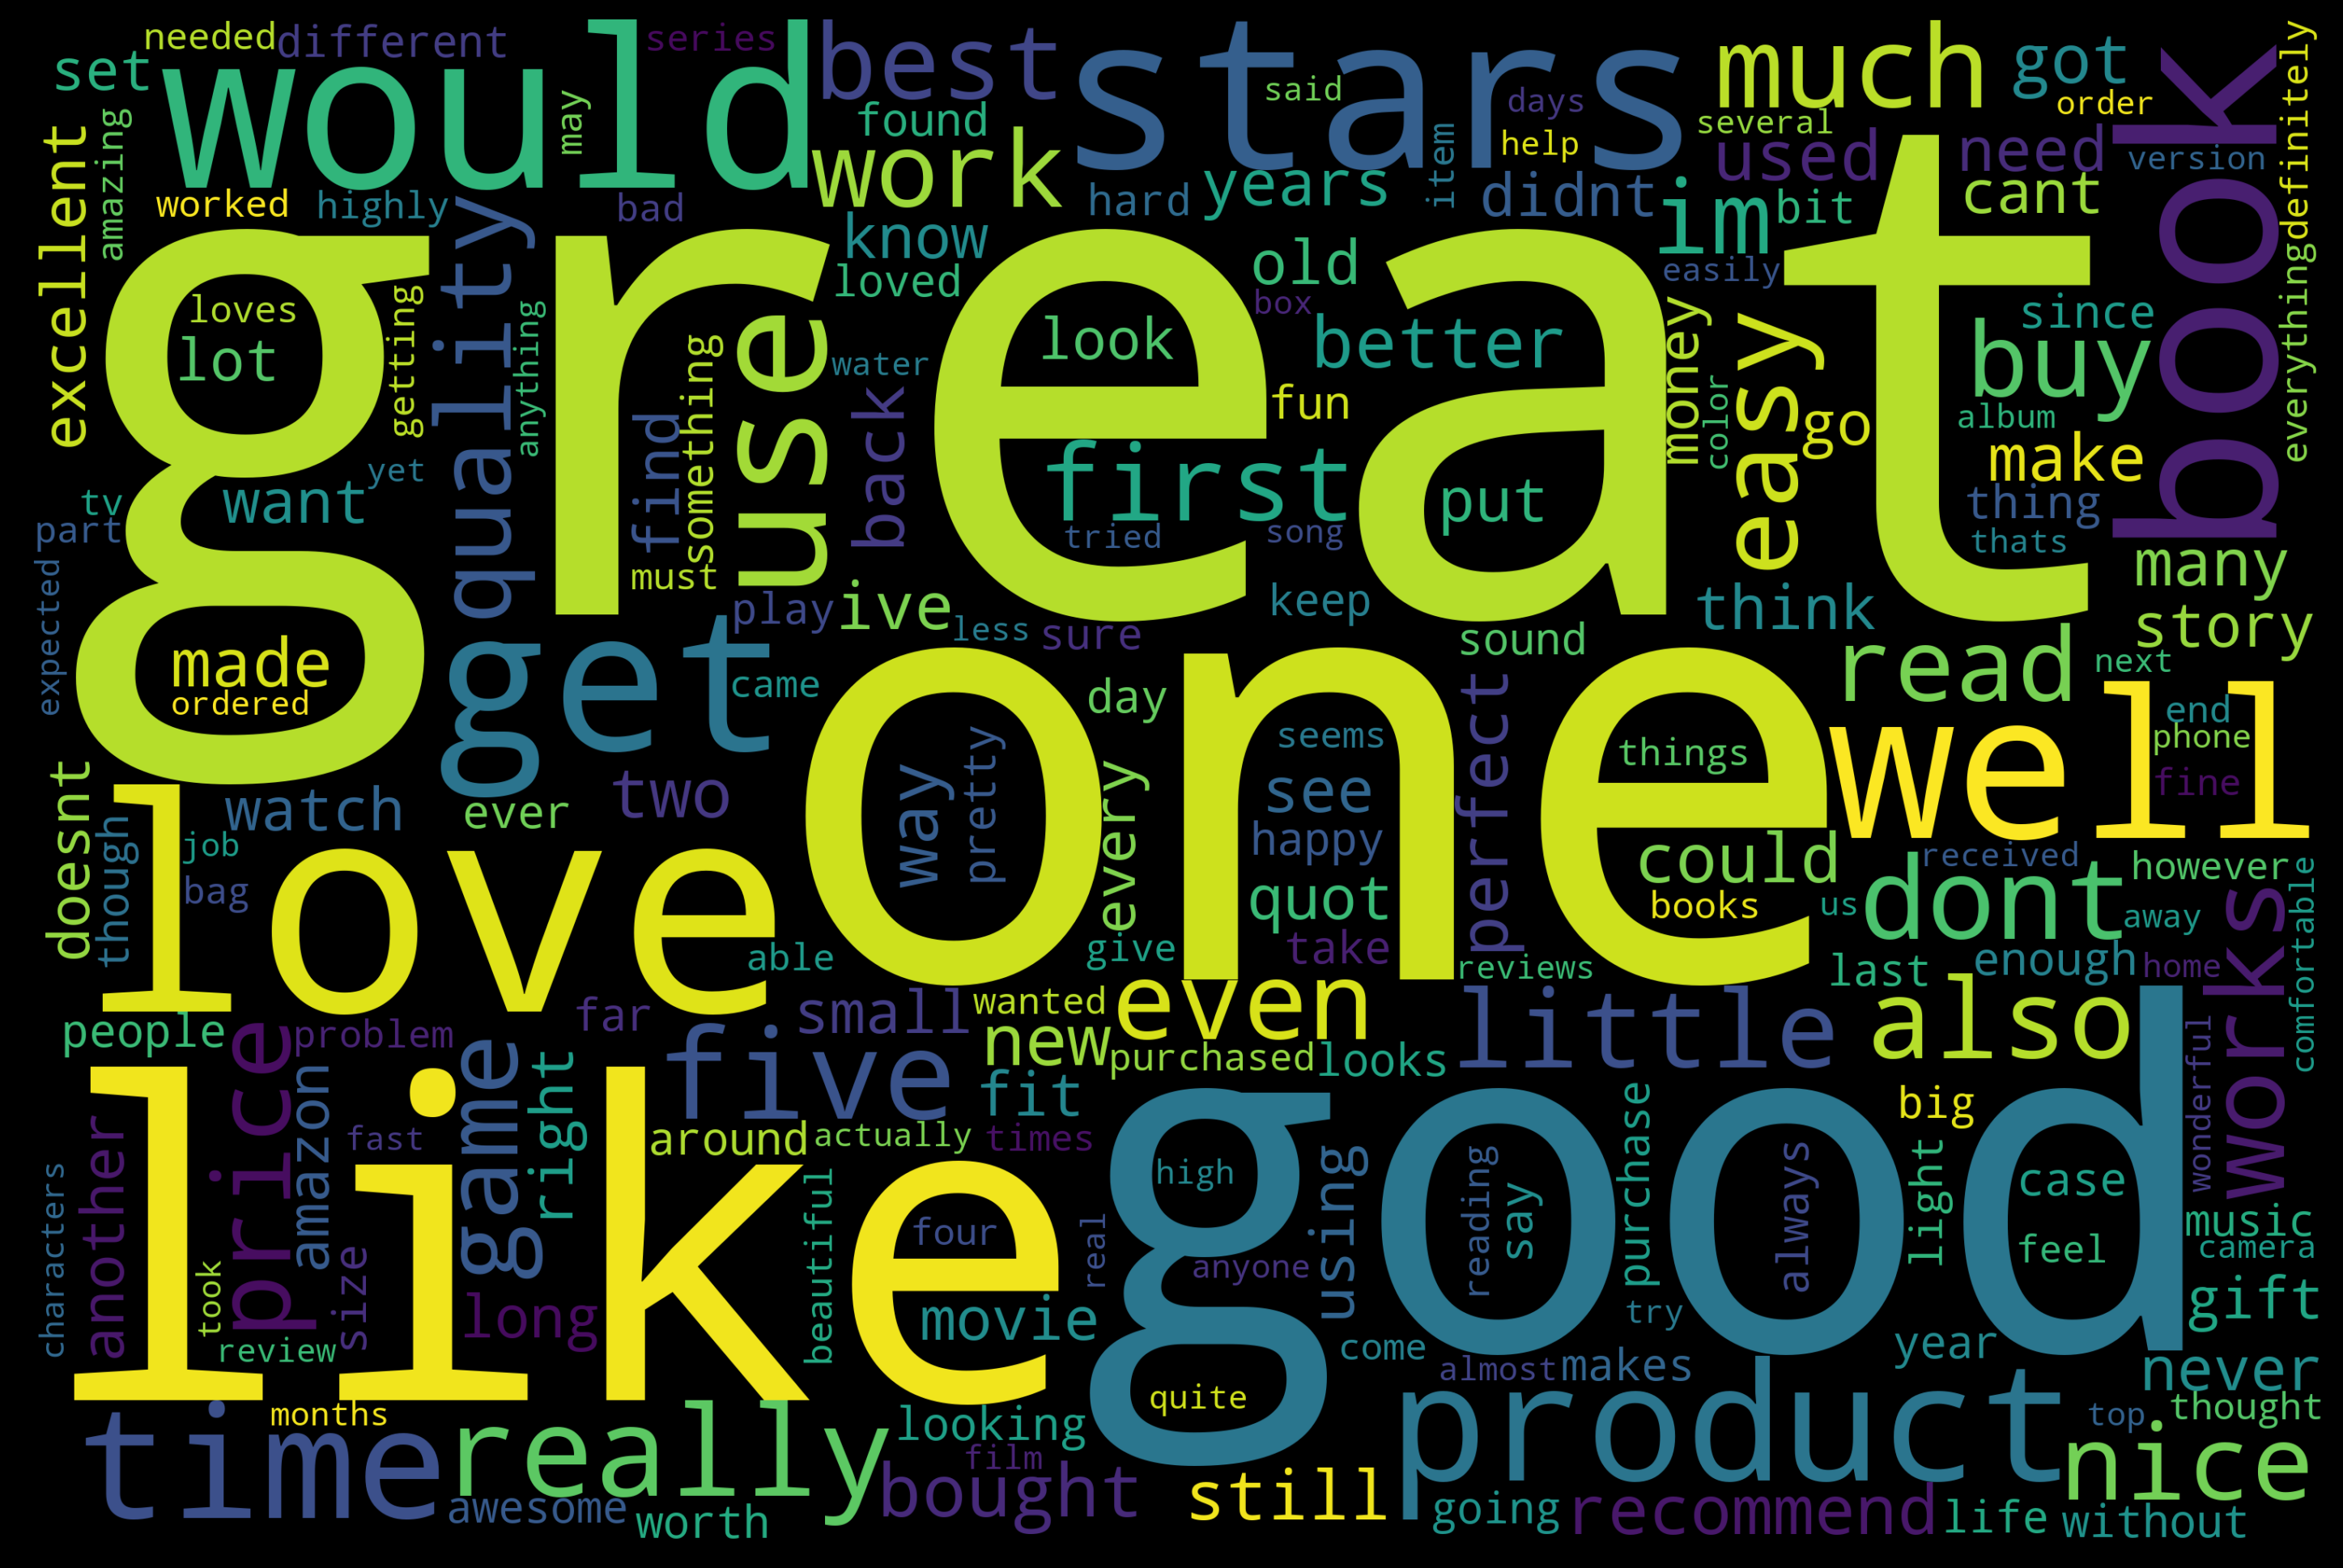

In [49]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = stop_words).generate_from_frequencies(dict(reviews_freqdist))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('All Words')
plt.tight_layout(pad=0)
plt.savefig('all_words_cloud.png')
plt.show()

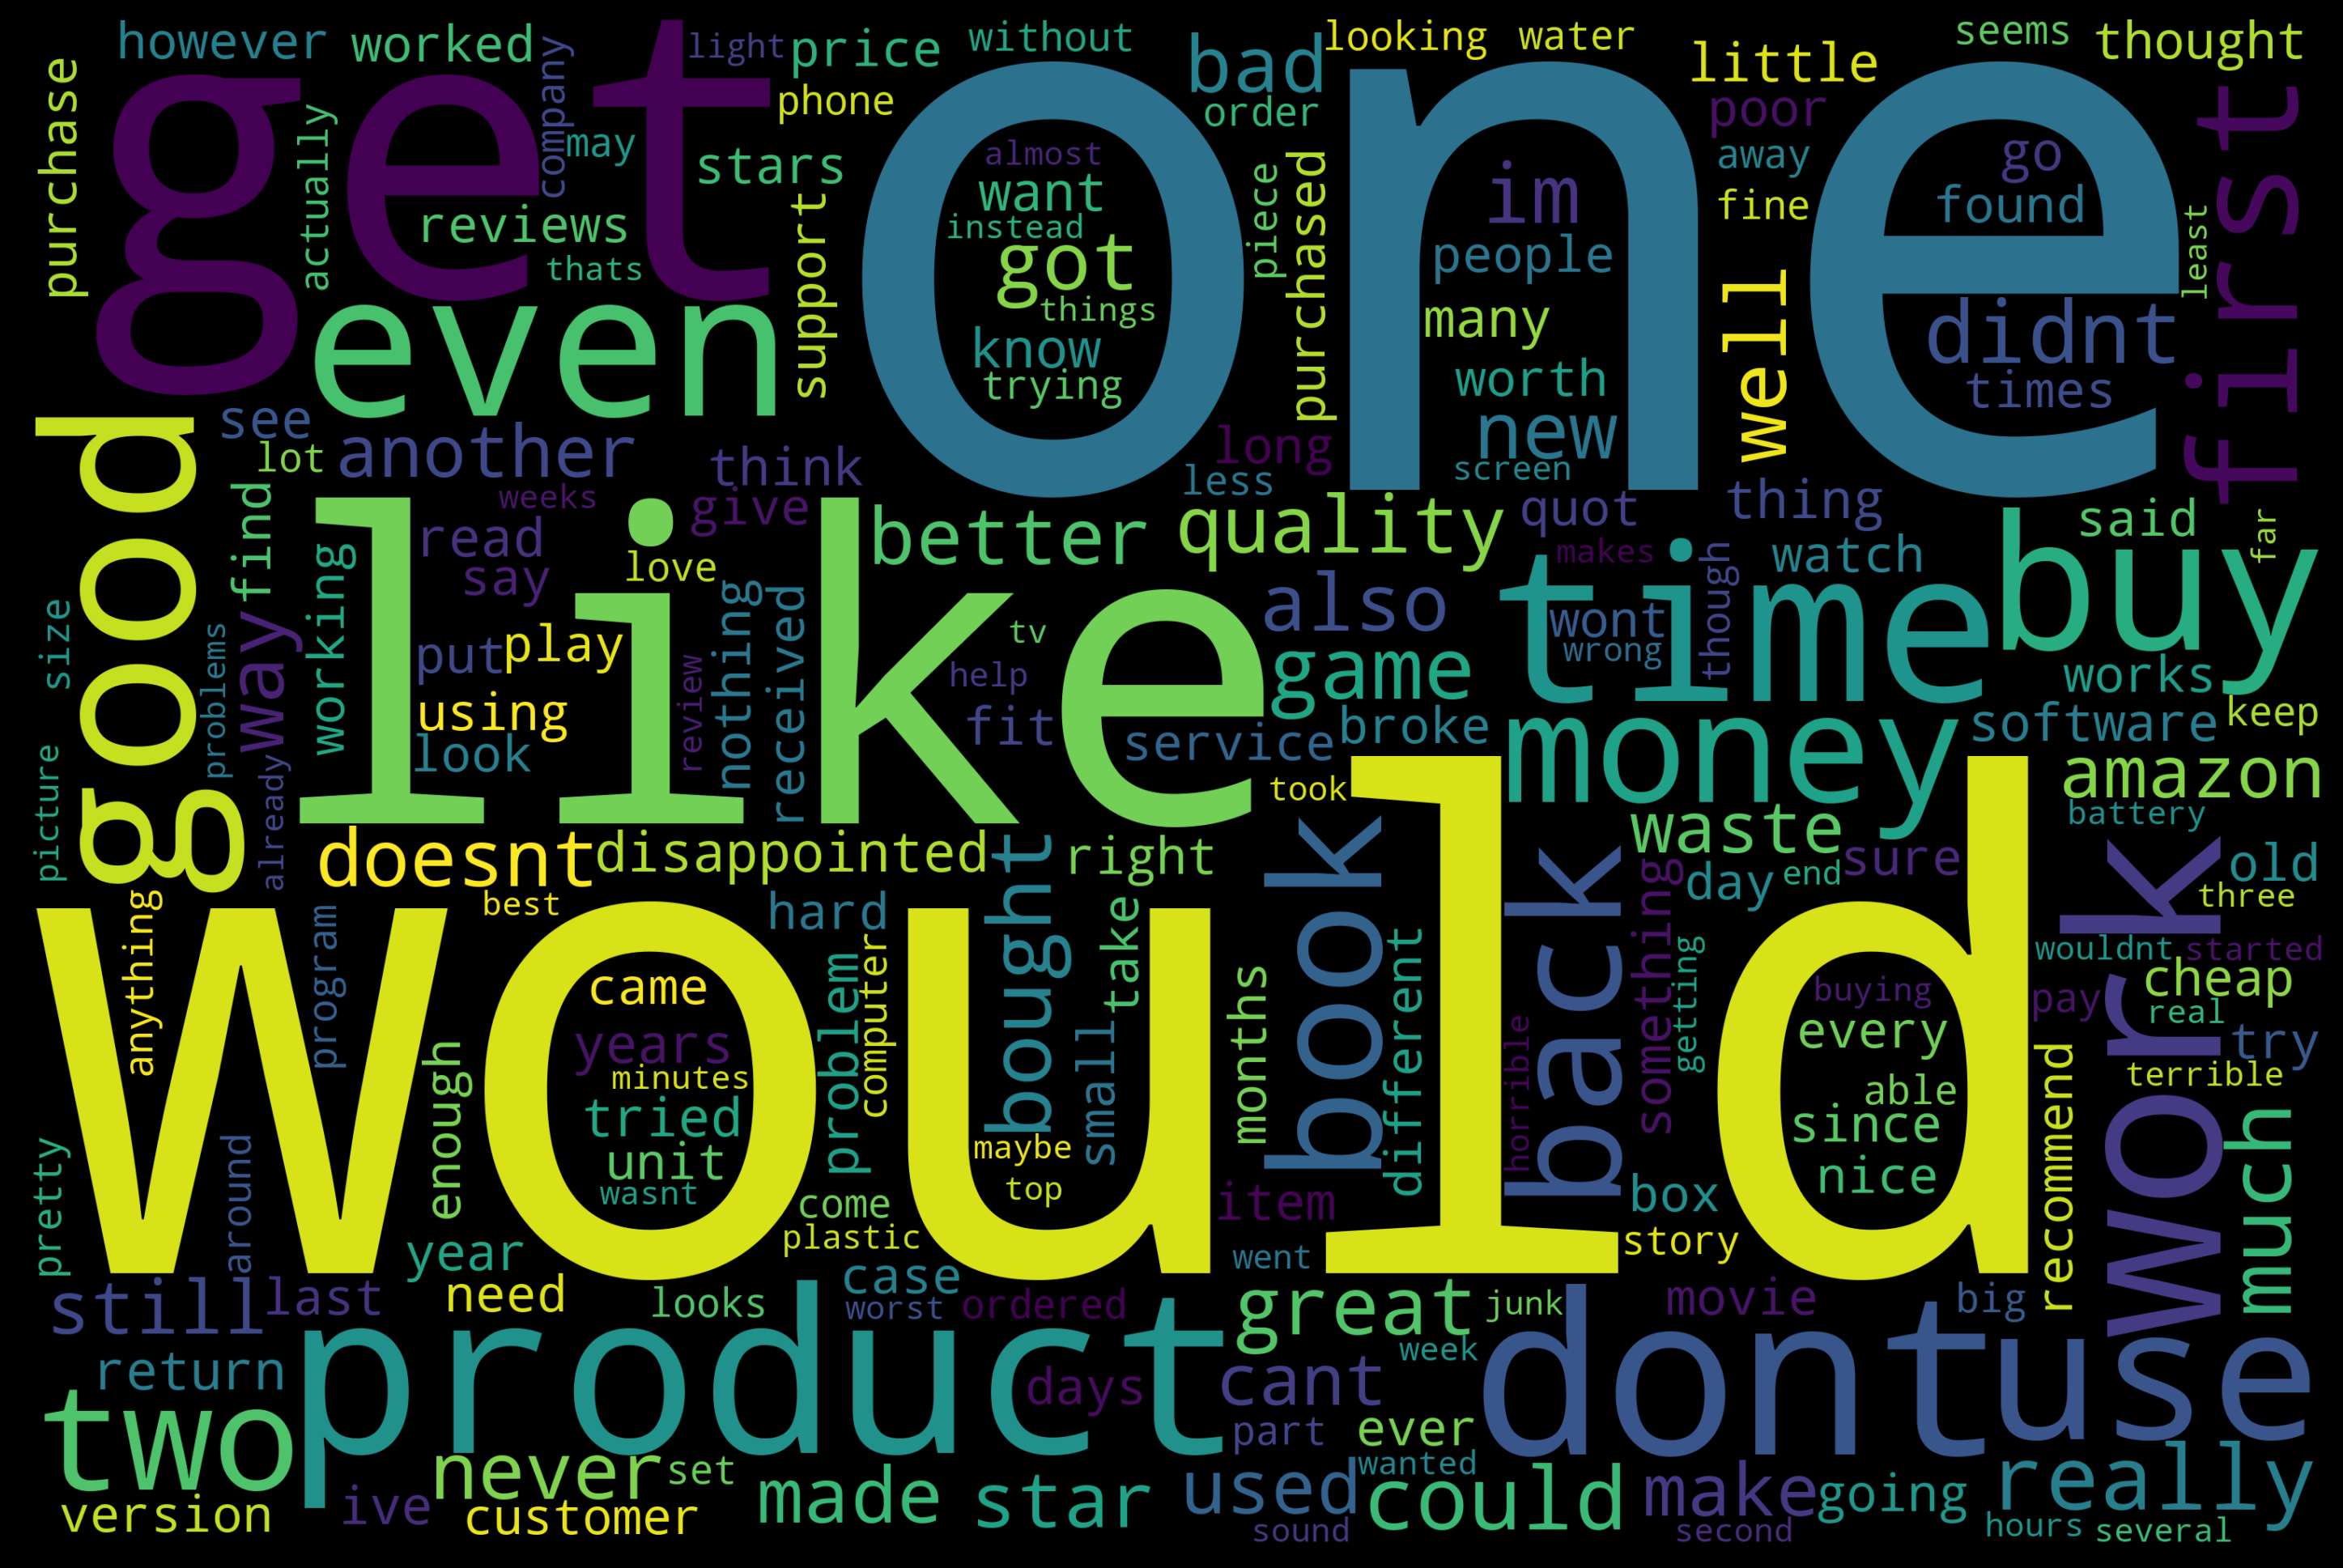

In [50]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = stop_words).generate_from_frequencies(dict(neg_reviews_freqdist))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Negative Words')
plt.tight_layout(pad=0)
plt.savefig('neg_words_cloud.png')
plt.show()

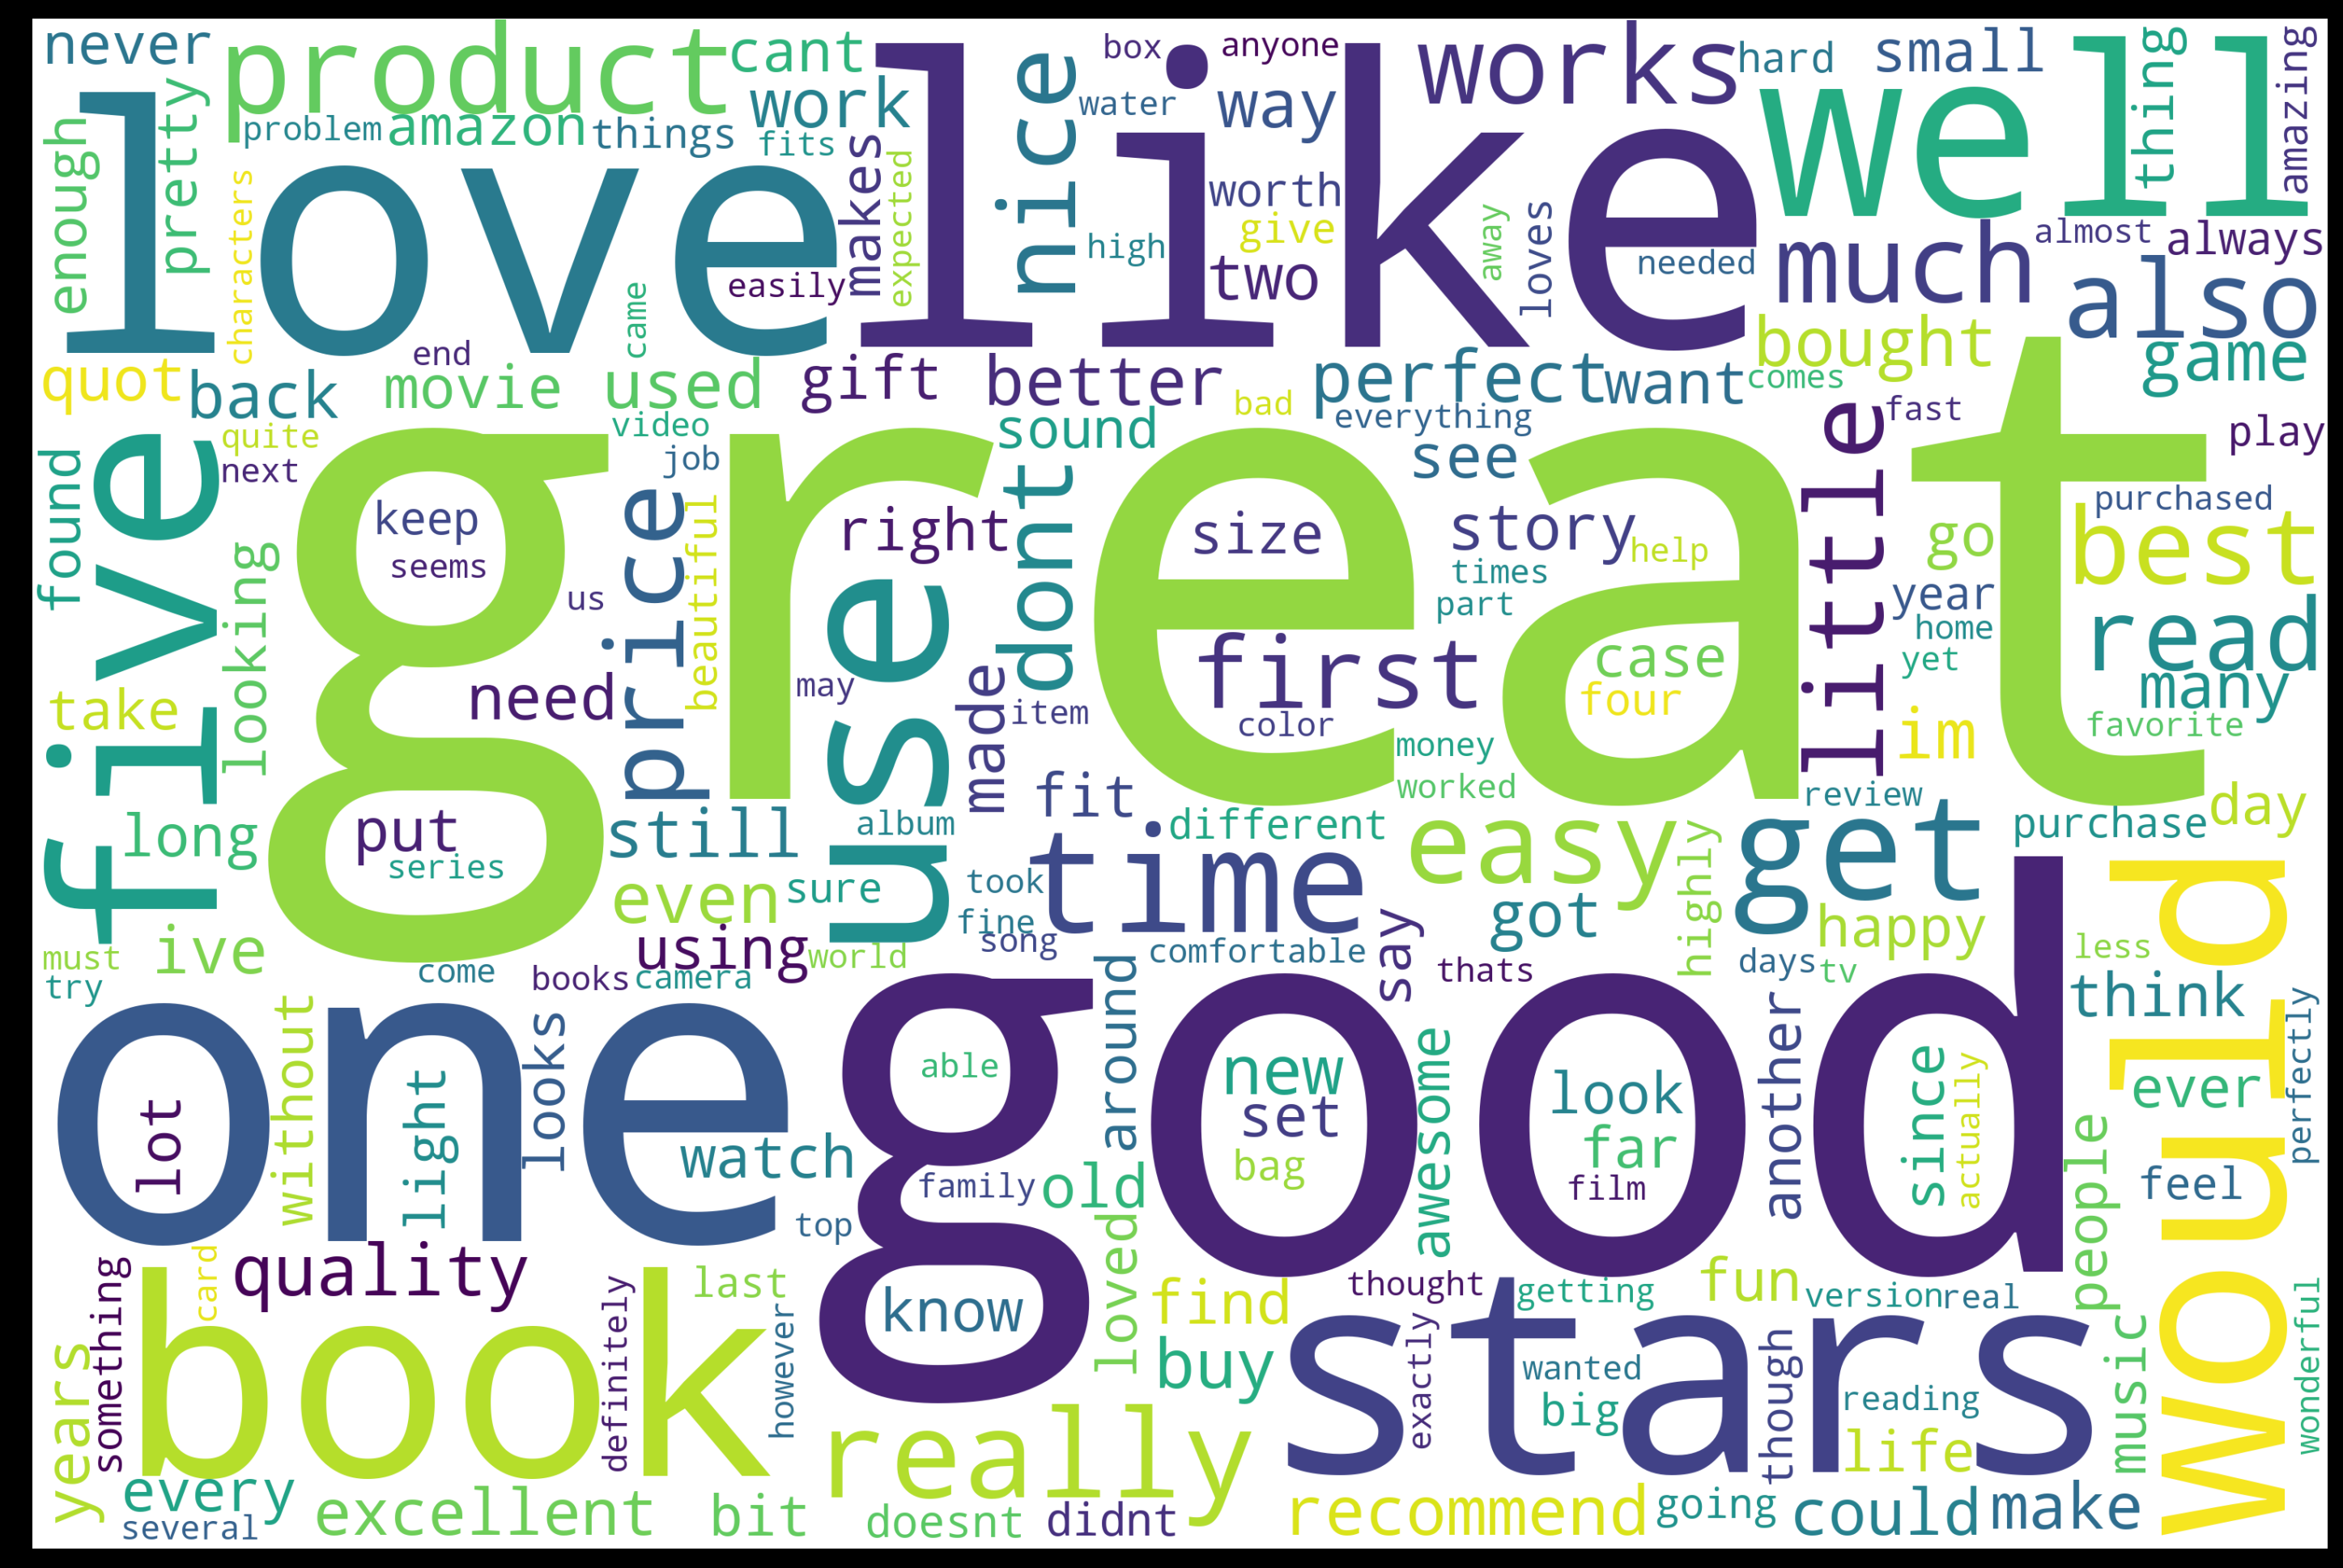

In [51]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = stop_words).generate_from_frequencies(dict(pos_reviews_freqdist))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Positive Words')
plt.tight_layout(pad=0)
plt.savefig('pos_words_cloud.png')
plt.show()

In [52]:
df.to_csv('cleaned_tokenized_stopped_data.csv.zip', index=False, compression='zip')

In [53]:
df = pd.read_csv('cleaned_tokenized_stopped_data.csv.zip')

In [54]:
x = df.drop(['sentiment'], axis=1)
y = df['sentiment']

In [55]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=44)

In [56]:
x_test.shape

(84761, 16)

In [57]:
x_train.head()

customer_id  product_id  product_parent        product_category  \
258137     17458906  B00BBLAA0M       447133549                 Grocery   
74081      36561476  B0002423YK       727360026                Software   
4660       28265489  B00B3UFWFY          290506                Wireless   
370579     13042006  B00APQJROO        59000392                  Camera   
330753     36597343  B002Q63JX6       623630268  Digital_Music_Purchase   

        helpful_votes  total_votes vine verified_purchase  \
258137            2.0          2.0    N                 Y   
74081             7.0         13.0    N                 N   
4660              0.0          0.0    N                 Y   
370579            1.0          2.0    N                 Y   
330753            0.0          0.0    N                 Y   

                        review_headline  \
258137                   best tea ever!   
74081          microsoft upgrade review   
4660    this made her especially happy.   
370579                 not for lumix zs   
330753                       five stars   

                                              review_body  \
258137  i love this tea!  no bitter &;bite&; if overbr...   
74081   i attempted to install on one of my computers ...   
4660    my niece is blakes biggest fan, so anything re...   
370579  this case does not fit the lumix zs-. if you t...   
330753                        this song totally rocks!!!!   

                                tokenized_review_headline  \
258137                       ['best', 'tea', 'ever', '!']   
74081                  ['microsoft', 'upgrade', 'review']   
4660    ['this', 'made', 'her', 'especially', 'happy',...   
370579                      ['not', 'for', 'lumix', 'zs']   
330753                                  ['five', 'stars']   

                                    tokenized_review_body  \
258137  ['i', 'love', 'this', 'tea', '!', 'no', 'bitte...   
74081   ['i', 'attempted', 'to', 'install', 'on', 'one...   
4660    ['my', 'niece', 'is', 'blakes', 'biggest', 'fa...   
370579  ['this', 'case', 'does', 'not', 'fit', 'the', ...   
330753  ['this', 'song', 'totally', 'rocks', '!', '!',...   

                   stopped_review_headline  \
258137             ['best', 'tea', 'ever']   
74081   ['microsoft', 'upgrade', 'review']   
4660       ['made', 'especially', 'happy']   
370579                     ['lumix', 'zs']   
330753                   ['five', 'stars']   

                                      stopped_review_body  \
258137  ['love', 'tea', 'bitter', 'bite', 'overbrewed'...   
74081   ['attempted', 'install', 'one', 'computers', '...   
4660    ['niece', 'blakes', 'biggest', 'fan', 'anythin...   
370579  ['case', 'fit', 'lumix', 'zs-', 'try', 'fasten...   
330753                       ['song', 'totally', 'rocks']   

                                          body_pos_tagged  \
258137  [('love', 'VB'), ('tea', 'NN'), ('bitter', 'JJ...   
74081   [('attempted', 'VBN'), ('install', 'JJ'), ('on...   
4660    [('niece', 'RB'), ('blakes', 'NNS'), ('biggest...   
370579  [('case', 'NN'), ('fit', 'JJ'), ('lumix', 'NN'...   
330753  [('song', 'NN'), ('totally', 'RB'), ('rocks', ...   

                                      headline_pos_tagged  
258137   [('best', 'JJS'), ('tea', 'NN'), ('ever', 'RB')]  
74081   [('microsoft', 'JJ'), ('upgrade', 'NN'), ('rev...  
4660    [('made', 'VBN'), ('especially', 'RB'), ('happ...  
370579                    [('lumix', 'NN'), ('zs', 'NN')]  
330753                 [('five', 'CD'), ('stars', 'NNS')]

In [58]:
x_test.shape

(84761, 16)

In [59]:
vectorizer = TfidfVectorizer()
tfidf_train = vectorizer.fit_transform(x_train['stopped_review_body'])
tfidf_test = vectorizer.transform(x_test['stopped_review_body'])

In [60]:
tfidf_train.shape

(339043, 189963)

In [61]:
tfidf_test.shape

(84761, 189963)

In [62]:
print(tfidf_test[0])

  (0, 184576)	0.2914203014481287
  (0, 98985)	0.12974181846391486
  (0, 98871)	0.23093958957489424
  (0, 91534)	0.617448638384903
  (0, 79127)	0.3567637896288296
  (0, 68544)	0.13398001019731473
  (0, 67026)	0.18263981460682865
  (0, 66142)	0.1908143446713174
  (0, 56976)	0.14977804012261234
  (0, 24758)	0.15591009894880034
  (0, 23920)	0.36471135965803503
  (0, 23908)	0.26250923129216125


In [63]:
non_zero_cols = tfidf_train.nnz / float(tfidf_train.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(tfidf_train.shape[1]))
print('Percentage of columns containing 0: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Articles: 27.1792427509195
Percentage of columns containing 0: 0.9998569234916751


#### Start with Multinomial Naive Bayes and Random Forrest Classifiers  
We will create a DataFrame to store scoring metrics for comparison.

In [64]:
results = pd.DataFrame()

In [65]:
nb_classifier = MultinomialNB()
rf_classifier = RandomForestClassifier(n_estimators=100)

In [66]:
rf_classifier.fit(tfidf_train, y_train)
rf_train_preds = rf_classifier.predict(tfidf_train)
rf_test_preds = rf_classifier.predict(tfidf_test)

In [67]:
nb_classifier.fit(tfidf_train, y_train)
nb_train_preds = nb_classifier.predict(tfidf_train)
nb_test_preds = nb_classifier.predict(tfidf_test)

In [68]:
nb_train_score = accuracy_score(y_train, nb_train_preds)
nb_test_score = accuracy_score(y_test, nb_test_preds)
results = results.append({'classifier':'nb_classifier',
                'training_accuracy':nb_train_score,
                'testing_accuracy':nb_test_score},ignore_index=True)
rf_train_score = accuracy_score(y_train, rf_train_preds)
rf_test_score = accuracy_score(y_test, rf_test_preds)
results = results.append({'classifier':'rf_classifier',
                'training_accuracy':rf_train_score,
                'testing_accuracy':rf_test_score},ignore_index=True)

print("Multinomial Naive Bayes")
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(nb_train_score, nb_test_score))
print("")
print('-~-'*21)
print("")
print('Random Forest')
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(rf_train_score, rf_test_score))

Multinomial Naive Bayes
Training Accuracy: 0.8533 		 Testing Accuracy: 0.8482

-~--~--~--~--~--~--~--~--~--~--~--~--~--~--~--~--~--~--~--~--~-

Random Forest
Training Accuracy: 0.9986 		 Testing Accuracy: 0.8886


#### Pickle models for future use

In [69]:
save_classifier = open('nb_classifier.pickle', 'wb')
pickle.dump(nb_classifier, save_classifier)
save_classifier.close()

save_classifier = open('rf_classifier.pickle', 'wb')
pickle.dump(rf_classifier, save_classifier)
save_classifier.close()

### Trying Logistic Regression  
First on the whole review body which has been POS tagged

In [70]:
vectorizer = TfidfVectorizer()
pos_tfidf_train = vectorizer.fit_transform(x_train['body_pos_tagged'])
pos_tfidf_test = vectorizer.transform(x_test['body_pos_tagged'])

In [71]:
pos_model = LogisticRegression(solver='saga')
pos_model.fit(pos_tfidf_train, y_train)

pos_predictions = pos_model.predict(pos_tfidf_test)

In [72]:
pos_test_accuracy = pos_model.score(pos_tfidf_test, y_test)
pos_train_accuracy = pos_model.score(pos_tfidf_train, y_train)
results = results.append({'classifier':'POS_model',
                'training_accuracy':pos_train_accuracy,
                'testing_accuracy':pos_test_accuracy},ignore_index=True)
print('POS Train Accuracy ', pos_train_accuracy, 'POS Test Accuracy ', pos_test_accuracy)

POS Train Accuracy  0.9339582294871152 POS Test Accuracy  0.925307629688182


In [73]:
save_classifier = open('pos_model.pickle', 'wb')
pickle.dump(pos_model, save_classifier)
save_classifier.close()

In [74]:
# Adding BiGrams for model

In [75]:
#vectorizer = TfidfVectorizer()
#bi_gram_tfidf_train = vectorizer.fit_transform(x_train['bi_grams_body'])
#bi_gram_tfidf_test = vectorizer.transform(x_test['bi_grams_body'])

In [76]:
#bi_gram_model = LogisticRegression(solver='saga')
#bi_gram_model.fit(bi_gram_tfidf_train, y_train)
#
#bi_gram_predictions = bi_gram_model.predict(bi_gram_tfidf_test)

In [77]:
#bi_gram_model.score(bi_gram_tfidf_test, y_test), bi_gram_model.score(bi_gram_tfidf_train, y_train)

In [78]:
#save_classifier = open('bi_gram_model.pickle', 'wb')
#pickle.dump(bi_gram_model, save_classifier)
#save_classifier.close()

#### Now just on the review body with stop words removed

In [79]:
vectorizer = TfidfVectorizer()
stop_tfidf_train = vectorizer.fit_transform(x_train['stopped_review_body'])
stop_tfidf_test = vectorizer.transform(x_test['stopped_review_body'])

stop_model = LogisticRegression(penalty='l1',solver='liblinear', max_iter=200)
stop_model.fit(stop_tfidf_train, y_train)

stop_predictions = stop_model.predict(stop_tfidf_test)

In [80]:
stop_model_test_accuracy = stop_model.score(stop_tfidf_test, y_test)
stop_model_train_accuracy = stop_model.score(stop_tfidf_test, y_test)
results = results.append({'classifier':'stop_model',
                'training_accuracy':stop_model_train_accuracy,
                'testing_accuracy':stop_model_test_accuracy},ignore_index=True)
print('stop model Train Accuracy ', stop_model_train_accuracy, 'stop model Test Accuracy ', stop_model_test_accuracy)

stop model Train Accuracy  0.9263576408961669 stop model Test Accuracy  0.9263576408961669


In [81]:
save_classifier = open('stop_model.pickle', 'wb')
pickle.dump(stop_model, save_classifier)
save_classifier.close()

#### Now to see how just the review headline performs

In [82]:
vectorizer = TfidfVectorizer()
stop_h_tfidf_train = vectorizer.fit_transform(x_train['stopped_review_headline'])
stop_h_tfidf_test = vectorizer.transform(x_test['stopped_review_headline'])

stop_h_model = LogisticRegression(penalty='l1',solver='saga')
stop_h_model.fit(stop_h_tfidf_train, y_train)

stop_h_predictions = stop_h_model.predict(stop_h_tfidf_test)

In [83]:
stop_h_model_test_accuracy = stop_h_model.score(stop_h_tfidf_train, y_train)
stop_h_model_train_accuracy = stop_h_model.score(stop_h_tfidf_test, y_test)
results = results.append({'classifier':'stop_h_model',
                'training_accuracy':stop_h_model_train_accuracy,
                'testing_accuracy':stop_h_model_test_accuracy},ignore_index=True)
print('stop h model Train Accuracy ', stop_h_model_train_accuracy, 'stop h model Test Accuracy ', stop_h_model_test_accuracy)

stop h model Train Accuracy  0.9151968476068003 stop h model Test Accuracy  0.9198390764593282


In [84]:
save_classifier = open('stop-h_model.pickle', 'wb')
pickle.dump(stop_h_model, save_classifier)
save_classifier.close()

#### This is just the tokenized headlines

In [85]:
 vectorizer = TfidfVectorizer()
tokenized_h_tfidf_train = vectorizer.fit_transform(x_train['tokenized_review_headline'])
tokenized_h_tfidf_test = vectorizer.transform(x_test['tokenized_review_headline'])

tokenized_h_model = LogisticRegression(penalty='l1',solver='liblinear', max_iter=200)
tokenized_h_model.fit(tokenized_h_tfidf_train, y_train)

tokenized_h_predictions = tokenized_h_model.predict(tokenized_h_tfidf_test)

In [86]:
tokenized_h_train_score = tokenized_h_model.score(tokenized_h_tfidf_train, y_train)
tokenized_h_test_score = tokenized_h_model.score(tokenized_h_tfidf_test, y_test)
results = results.append({'classifier':'tokenized_h_model',
                'training_accuracy':tokenized_h_train_score,
                'testing_accuracy':tokenized_h_test_score},ignore_index=True)
print("LogisticRegression on Tokenized Headlline")
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(tokenized_h_train_score, tokenized_h_test_score))
print("")


LogisticRegression on Tokenized Headlline
Training Accuracy: 0.9327 		 Testing Accuracy: 0.9288



In [87]:
save_classifier = open('tokenized_h_model.pickle', 'wb')
pickle.dump(tokenized_h_model, save_classifier)
save_classifier.close()

#### The same model but using the Review Body as the target

In [88]:
 vectorizer = TfidfVectorizer()
tokenized_b_tfidf_train = vectorizer.fit_transform(x_train['tokenized_review_body'])
tokenized_b_tfidf_test = vectorizer.transform(x_test['tokenized_review_body'])

tokenized_b_model = LogisticRegression(penalty='l1',solver='liblinear', max_iter=200)
tokenized_b_model.fit(tokenized_b_tfidf_train, y_train)

tokenized_b_predictions = tokenized_b_model.predict(tokenized_b_tfidf_test)

In [89]:
tokenized_b_train_score = tokenized_b_model.score(tokenized_b_tfidf_train, y_train)
tokenized_b_test_score = tokenized_b_model.score(tokenized_b_tfidf_test, y_test)
results = results.append({'classifier':'tokenized_b_model',
                'training_accuracy':tokenized_b_train_score,
                'testing_accuracy':tokenized_b_test_score},ignore_index=True)
print("LogisticRegression on Tokenized Body")
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(tokenized_b_train_score, tokenized_b_test_score))
print("")

LogisticRegression on Tokenized Body
Training Accuracy: 0.9384 		 Testing Accuracy: 0.9327



In [90]:
save_classifier = open('tokenized_b_model.pickle', 'wb')
pickle.dump(tokenized_b_model, save_classifier)
save_classifier.close()

#### Now to try LinearSVC on the headlines

In [91]:
 vectorizer = TfidfVectorizer()
tokenized_h_tfidf_train2 = vectorizer.fit_transform(x_train['tokenized_review_headline'])
tokenized_h_tfidf_test2 = vectorizer.transform(x_test['tokenized_review_headline'])

tokenized_h_model2 = LinearSVC()
tokenized_h_model2.fit(tokenized_h_tfidf_train2, y_train)

tokenized_h_predictions2 = tokenized_h_model2.predict(tokenized_h_tfidf_test2)

In [92]:
tokenized_h_train_score2 = tokenized_h_model2.score(tokenized_h_tfidf_train2, y_train)
tokenized_h_test_score2 = tokenized_h_model2.score(tokenized_h_tfidf_test2, y_test)
results = results.append({'classifier':'tokenized_h_model2',
                'training_accuracy':tokenized_h_train_score2,
                'testing_accuracy':tokenized_h_test_score2},ignore_index=True)
print("Linear SVC on Tokenized Headlline")
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(tokenized_h_train_score2, tokenized_h_test_score2))
print("")

Linear SVC on Tokenized Headlline
Training Accuracy: 0.9473 		 Testing Accuracy: 0.9276



In [93]:
save_classifier = open('tokenized_h_model2.pickle', 'wb')
pickle.dump(tokenized_h_model2, save_classifier)
save_classifier.close()

In [94]:
tokenized_b_tfidf_train2 = vectorizer.fit_transform(x_train['tokenized_review_body'])
tokenized_b_tfidf_test2 = vectorizer.transform(x_test['tokenized_review_body'])

tokenized_b_model2 = LinearSVC()
tokenized_b_model2.fit(tokenized_b_tfidf_train2, y_train)

tokenized_b_predictions2 = tokenized_b_model2.predict(tokenized_b_tfidf_test2)

In [95]:
tokenized_b_train_score2 = tokenized_b_model2.score(tokenized_b_tfidf_train2, y_train)
tokenized_b_test_score2 = tokenized_b_model2.score(tokenized_b_tfidf_test2, y_test)
results = results.append({'classifier':'tokenized_b_model2',
                'training_accuracy':tokenized_b_train_score2,
                'testing_accuracy':tokenized_b_test_score2},ignore_index=True)
print("Linear SVC on Tokenized Body")
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(tokenized_b_train_score2, tokenized_b_test_score2))
print("")

Linear SVC on Tokenized Body
Training Accuracy: 0.9601 		 Testing Accuracy: 0.9323



In [96]:
save_classifier = open('tokenized_b_model2.pickle', 'wb')
pickle.dump(tokenized_b_model2, save_classifier)
save_classifier.close()

In [97]:
display(results.sort_values('testing_accuracy', ascending=False))

classifier  testing_accuracy  training_accuracy
6   tokenized_b_model          0.932670           0.938368
8  tokenized_b_model2          0.932268           0.960117
5   tokenized_h_model          0.928776           0.932678
7  tokenized_h_model2          0.927644           0.947311
3          stop_model          0.926358           0.926358
2           POS_model          0.925308           0.933958
4        stop_h_model          0.919839           0.915197
1       rf_classifier          0.888628           0.998631
0       nb_classifier          0.848161           0.853296

### Looking at the model scores it appears that using LogisticRegresion on the Review Body has given us the best accuracy.

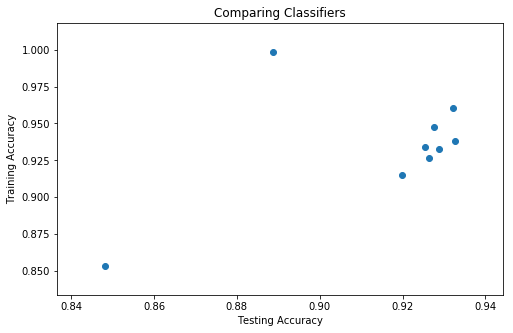

In [98]:
plt.figure(figsize=(8,5))
plt.scatter(results.testing_accuracy, results.training_accuracy)
plt.title('Comparing Classifiers')
plt.xlabel('Testing Accuracy')
plt.ylabel('Training Accuracy')
plt.show()
